# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel:
### Dimensionsreduzierung mit LDA und t-SNE mit besserer Hardware (4.Teil, Part 2)

In [18]:
! pip install psutil

In [5]:
import csv

from gensim import corpora, models
import gensim

In [6]:
def get_recipe_names():
    recipe_names = []
    skip_first = True # col name
    chef_file = '/input/chefkoch_rezepte_analysis_cleannames.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names.append(row[-1])
            except: 
                continue 
    return(recipe_names)

In [26]:
recipe_names = get_recipe_names()
print(len(recipe_names)) # Anzahl aller Rezeptnamen

316755


In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [13]:
import os
import argparse
import time
import lda
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

In [27]:
# unpack
n_topics = 40
n_iter = 500
n_top_words = 4
threshold = 0

##############################################################################
# train an LDA model

cvectorizer = CountVectorizer(min_df=1)
cvz = cvectorizer.fit_transform(recipe_names)

lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)


np.save('/output/lda_doc_topic_{}recipe_names{}topics_cloud_2.npy'.format(X_topics.shape[0], X_topics.shape[1]), X_topics)

np.save('/output/lda_topic_word_{}recipe_names{}topics_cloud_2.npy'.format(X_topics.shape[0], X_topics.shape[1]), lda_model.topic_word_)

print('\n>>> doc_topic & topic word written to disk\n')


>>> doc_topic & topic word written to disk



In [28]:
##############################################################################
# threshold and plot

_idx = np.amax(X_topics, axis=1) > threshold  # idx of recipe_names that > threshold
_topics = X_topics[_idx]

num_example = len(_topics)

In [29]:
import psutil
psutil.virtual_memory()

svmem(total=6783913984, available=5073215488, percent=25.2, used=3155136512, free=3628777472, active=1723863040, inactive=897683456, buffers=217370624, cached=1227067392, shared=17948672)

In [30]:
from sklearn.externals import joblib

In [31]:
# t-SNE: 50 -> 2D
tsne_model = TSNE(n_components=2, perplexity=5, verbose=2, random_state=0, angle=.7, learning_rate=150,
                    init='pca', n_iter=2500, n_iter_without_progress=100)
tsne_lda = tsne_model.fit_transform(_topics[:num_example])

# save tsne model
joblib.dump(tsne_lda, '/output/tsne_lda_cloud_2.pkl')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 316755 samples in 102.651s...
[t-SNE] Computed neighbors for 316755 samples in 4136.516s...
...
[t-SNE] Computed conditional probabilities for sample 316755 / 316755
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 10.156s
[t-SNE] Iteration 50: error = 151.1514435, gradient norm = 0.0008445 (50 iterations in 264.653s)
[t-SNE] Iteration 100: error = 149.9667511, gradient norm = 0.0015456 (50 iterations in 252.712s)
[t-SNE] Iteration 150: error = 138.6162567, gradient norm = 0.0015062 (50 iterations in 225.339s)
[t-SNE] Iteration 200: error = 134.5572662, gradient norm = 0.0013472 (50 iterations in 217.363s)
[t-SNE] Iteration 250: error = 102.0727081, gradient norm = 0.0012021 (50 iterations in 198.384s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.072708
[t-SNE] Iteration 300: error = 6.3521028, gradient norm = 0.0007236 (50 iterations in 192.837s)
Websocket connection lost. Re

[t-SNE] Iteration 1650: error = 2.6614108, gradient norm = 0.0000808 (50 iterations in 183.610s)
[t-SNE] Iteration 1700: error = 2.6466060, gradient norm = 0.0000778 (50 iterations in 175.392s)
[t-SNE] Iteration 1750: error = 2.6314242, gradient norm = 0.0000752 (50 iterations in 178.205s)
[t-SNE] Iteration 1800: error = 2.6227713, gradient norm = 0.0000726 (50 iterations in 187.986s)
[t-SNE] Iteration 1850: error = 2.6007292, gradient norm = 0.0000712 (50 iterations in 186.379s)
[t-SNE] Iteration 1900: error = 2.5695534, gradient norm = 0.0000686 (50 iterations in 184.655s)
[t-SNE] Iteration 1950: error = 2.5549016, gradient norm = 0.0000664 (50 iterations in 187.477s)
[t-SNE] Iteration 2000: error = 2.5401475, gradient norm = 0.0000643 (50 iterations in 190.000s)
[t-SNE] Iteration 2050: error = 2.4175959, gradient norm = 0.0000624 (50 iterations in 185.957s)
[t-SNE] Iteration 2100: error = 2.4010444, gradient norm = 0.0000607 (50 iterations in 187.163s)
[t-SNE] Iteration 2150: error 

['/output/tsne_lda_cloud_2.pkl']

In [32]:
# find the most probable topic for each recipe category
_lda_keys = []
for i in range(_topics.shape[0]):
    _lda_keys += _topics[i].argmax(),

# show topics and their top words
topic_summaries = []
topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    
# 40 colors
colormap = np.array([
    "#144c73", "#1f77b4", "#aec7e8", "#d6e2f3", "#c15a00", "#ff7f0e", "#ffbb78", "#ffe2c5",
    "#1c641c","#2ca02c", "#98df8a", "#cdefc6", "#951b1c", "#d62728", "#ff9896", "#ffe3e3",
    "#6e4196", "#9467bd", "#c5b0d5", "#eae2f0", "#5a3730", "#8c564b", "#c49c94","#dfcac5",
    "#d638a6", "#e377c2","#f0b6de", "#f7b6d2", "#fce4ee", "#595959", "#7f7f7f",
    "#c7c7c7","#ededed","#7c7c16", "#bcbd22", "#dbdb8d","#ededc7", "#0f7f8a",
    "#17becf", "#9edae5", "#daf1f5"
  ])

# plot
title = "[Recipe Topics] t-SNE visualization of LDA model trained on {} names, {} topics, thresholding at {} topic probability, {} iter ({} datapoints and top {} words)".format(X_topics.shape[0], n_topics, threshold, n_iter, num_example, n_top_words)

plot_lda = bp.figure(plot_width=2000, plot_height=1300, title=title,
                       tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                       x_axis_type=None, y_axis_type=None, min_border=1)
source = bp.ColumnDataSource(data={'x':tsne_lda[:, 0],'y':tsne_lda[:, 1], 'color':colormap[_lda_keys][:num_example],
                                  "content": recipe_names[:num_example],
                                  "topic_key": _lda_keys[:num_example]})
plot_lda.scatter(x='x', y='y',color='color',source=source)

topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(X_topics.shape[1]):
    plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

save(plot_lda, '/output/NEW_20_recipe_names_final_tsne_2_lda_viz_{}_{}_{}_{}_{}_{}.html'.format(
    X_topics.shape[0], n_topics, threshold, n_iter, num_example, n_top_words))

/usr/local/lib/python3.5/dist-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.5/dist-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/output/NEW_20_recipe_names_final_tsne_2_lda_viz_316755_40_0_500_316755_4.html'

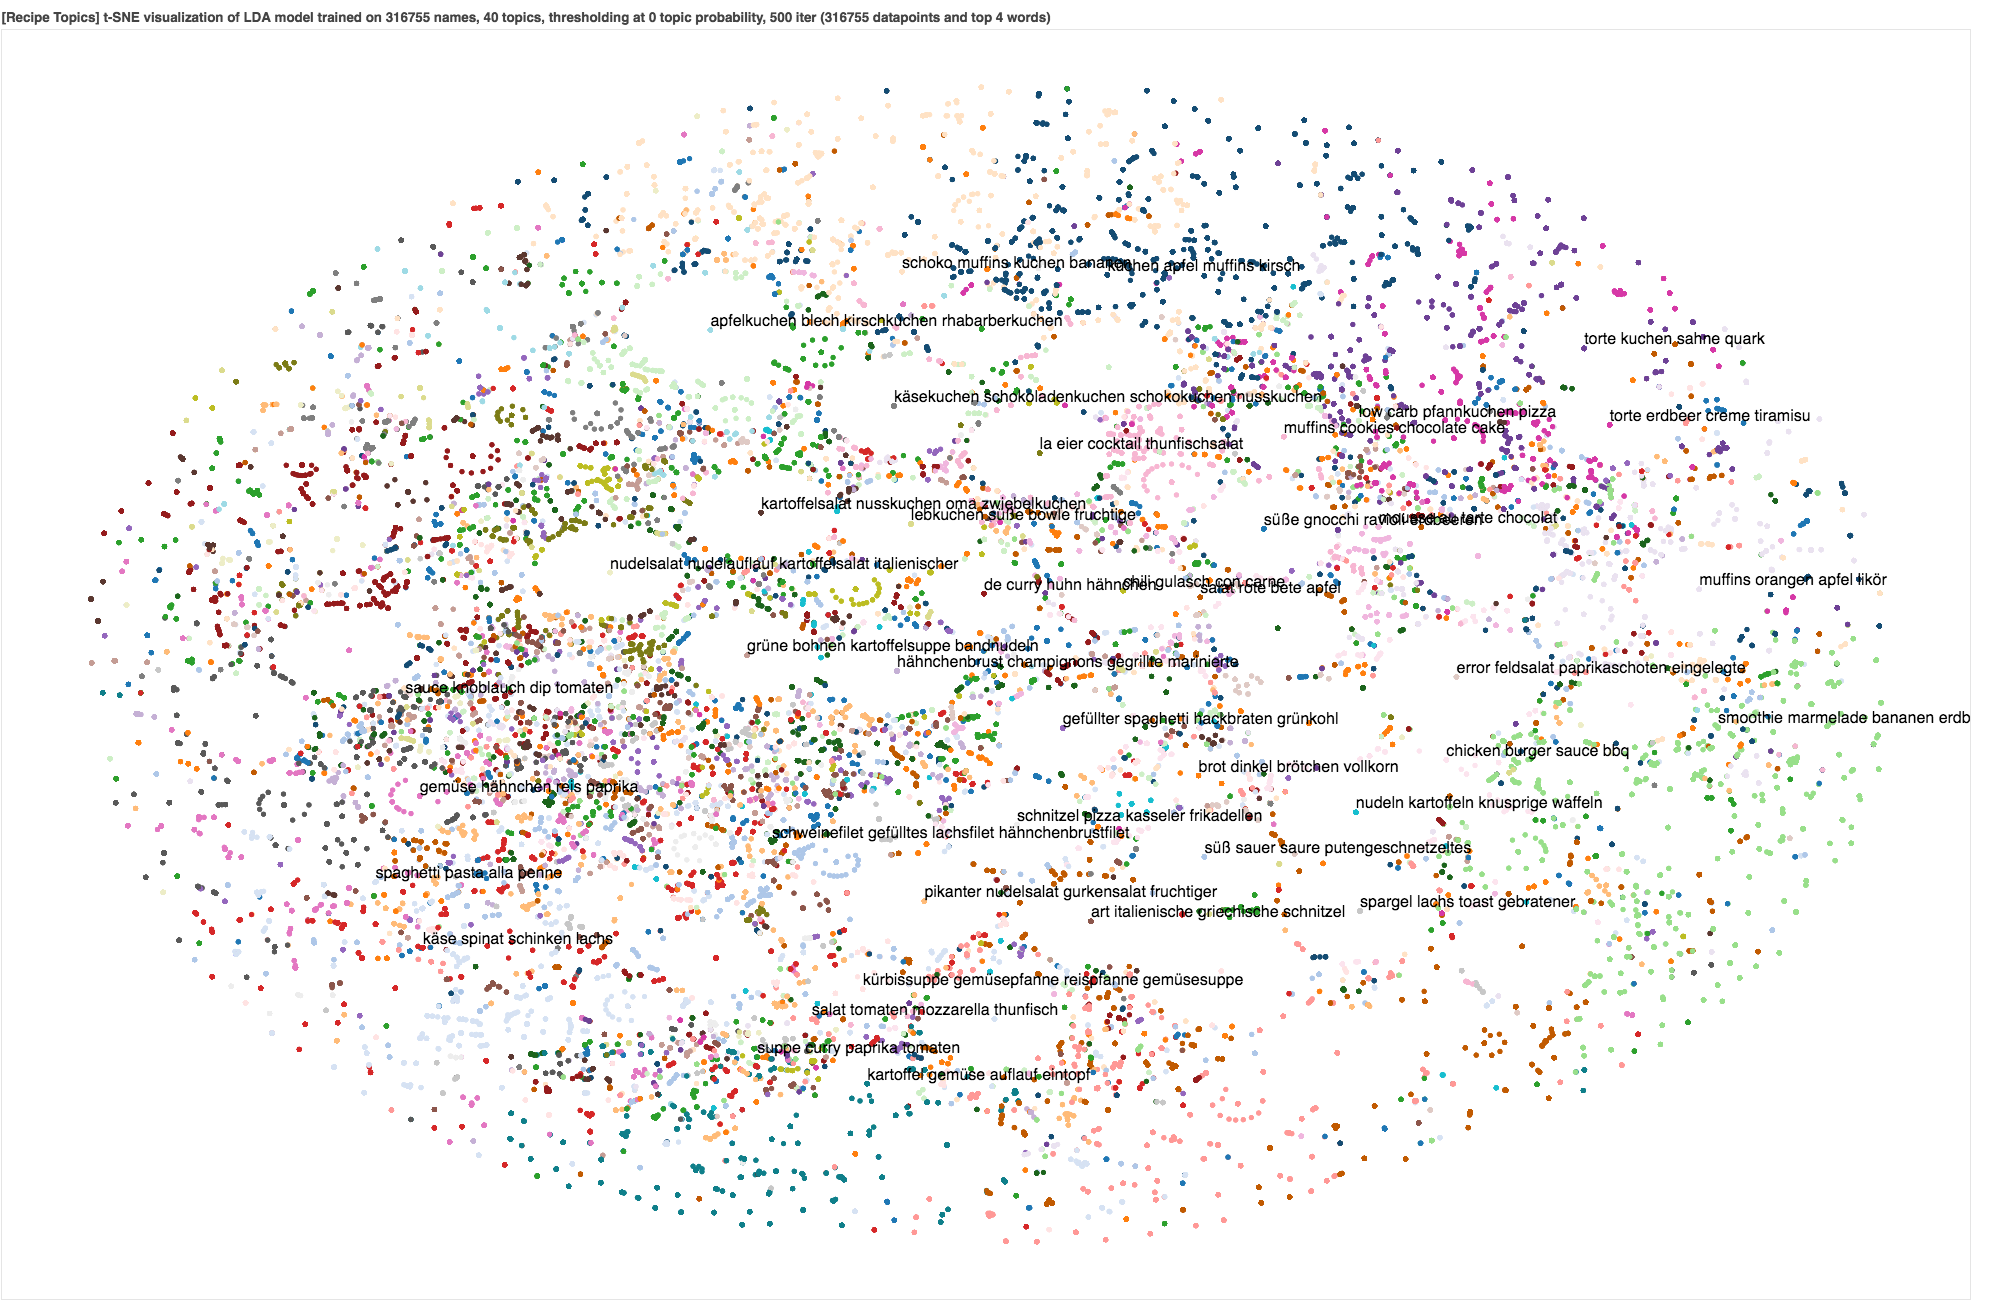

In [2]:
from IPython.display import Image
PATH = "/Users/Muriz/Desktop/download-1.png"
Image(filename = PATH, width='100%', height=140)

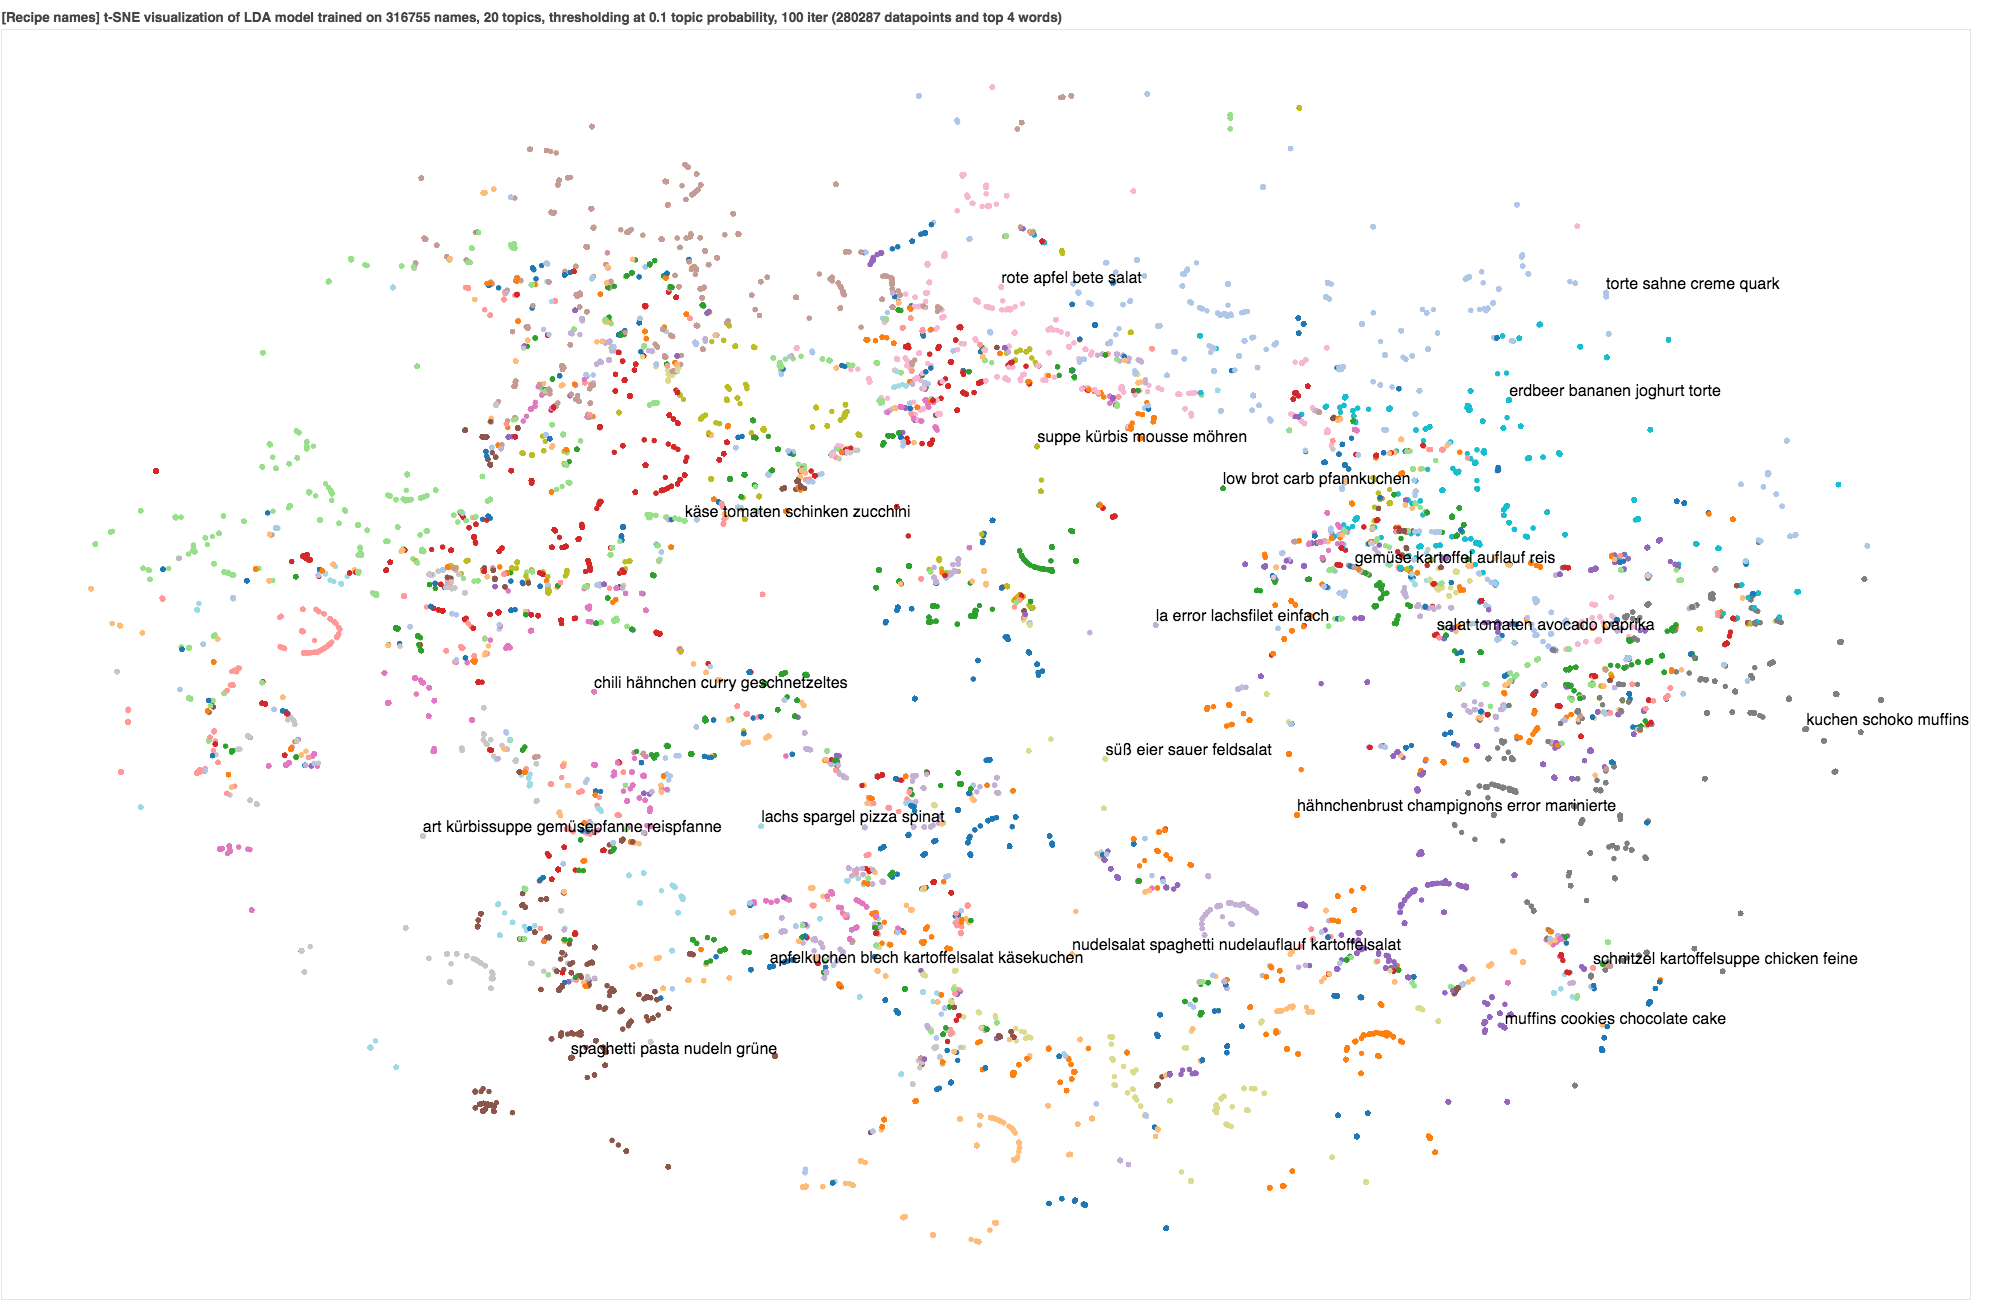

In [3]:
Image(filename = '/Users/Muriz/Desktop/download.png', width='100%', height=140)